# TVID
Bonzi Théo Image 2024

# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import time

In [3]:
def load_images(img1_path, img2_path):
    F1 = Image.open(img1_path, mode='r', formats=None)
    F2 = Image.open(img2_path, mode='r', formats=None)
    F1_grey = Image.open(img1_path, mode='r', formats=None).convert('L')
    F2_grey = Image.open(img2_path, mode='r', formats=None).convert('L')

    return F1, F2, F1_grey, F2_grey

In [4]:
dir_path = './data/'
img_1 = os.path.join(dir_path, 'LF052.jpg')
img_2 = os.path.join(dir_path, 'LF054.jpg')

F1, F2, F1_grey, F2_grey = load_images(img1_path=img_1, img2_path=img_2)

In [5]:
def plot_images(img1, img2):
    plt.figure(figsize=(20, 20))
    
    plt.subplot(1, 2, 1)
    plt.title('Image 1')
    plt.imshow(img1)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Image 2')
    plt.imshow(img2)
    plt.axis('off')

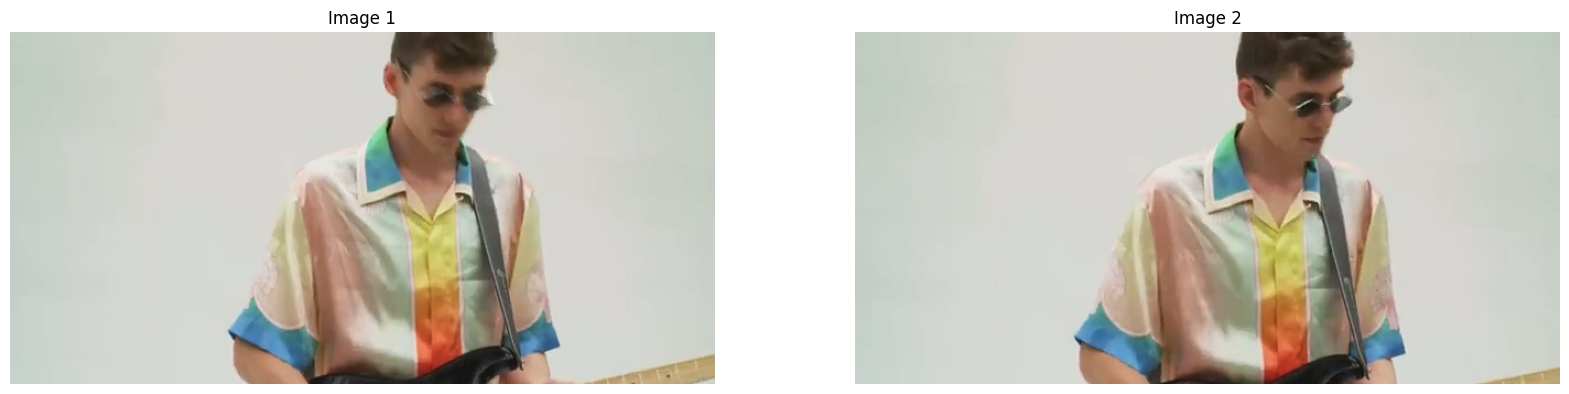

In [6]:
plot_images(F1, F2)

In [7]:
def image_to_float(img_1, img_2, img_grey_1, img_grey_2):
    f1 = np.asarray(img_1)
    f2 = np.asarray(img_2)
    f1_grey = np.asarray(img_grey_1) / 255
    f2_grey = np.asarray(img_grey_2) / 255
    
    return f1, f2, f1_grey, f2_grey

In [8]:
f1, f2, f1_grey, f2_grey = image_to_float(img_1=F1, img_2=F2, img_grey_1=F1_grey, img_grey_2=F2_grey)

# (A) Partant de deux frames F1 et F2 où F2 succède à F1 dans le temps, estimez par une méthode pixel-wise les vecteurs de mouvements des pixels de la frame F1 vers F2 (en admettant l’hypothèse de l’intensité constante).

In [9]:
def pixelwise_motion_vector(f1, f2, x, y, radius):
    """
    Calculate the motion vector for a pixel located at (x, y) by finding the best match within a window.
    
    Parameters:
    f1 (numpy.ndarray): The grayscale image at time t.
    f2 (numpy.ndarray): The grayscale image at time t+1.
    x (int): The x-coordinate of the pixel.
    y (int): The y-coordinate of the pixel.
    radius (int): The radius of the search window.
    
    Returns:
    tuple: The motion vector (delta_x, delta_y) representing the displacement.
    """
    # Create a window around the pixel in the first frame
    window_f1 = np.full((2*radius+1, 2*radius+1), f1[y, x])
    # Extract the corresponding window in the second frame
    window_f2 = f2[y-radius:y+radius+1, x-radius:x+radius+1]
    
    # Compute the difference between the two windows
    diff = np.abs(window_f2 - window_f1)
    # Find the position of the minimum difference
    miny, minx = np.unravel_index(np.argmin(diff, axis=None), diff.shape)
    
    # Calculate the motion vector
    # The displacement is negative because we're finding the match moving from f2 back to f1
    return -miny, -minx

In [10]:
def display_motion_vectors(v1, v2, step, radius, width, height, image, function_name):
    """
    Display motion vectors on the image using quiver plot.
    
    Parameters:
    v1 (list): The list of x-components of motion vectors.
    v2 (list): The list of y-components of motion vectors.
    step (int): The step size between pixels in the computation grid.
    width (int): The width of the image.
    height (int): The height of the image.
    image (numpy.ndarray): The image on which to overlay the motion vectors.
    function_name (str): The name of the vector computation function.
    """
    # Generate a grid of points at which vectors will be displayed
    x = np.arange(radius, width - radius, step)
    y = np.arange(radius, height - radius, step)
    X, Y = np.meshgrid(x, y)

    # Reshape the motion vectors for display
    sh1, sh2 = X.shape
    V1 = np.array(v1, dtype=float).reshape((sh2, sh1))
    V2 = np.array(v2, dtype=float).reshape((sh2, sh1))
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.imshow(image, cmap='gray')
    plt.title(function_name)
    plt.axis('off')
    
    # Plot the motion vectors
    ax.quiver(X, Y, V1, V2)
    plt.show()

In [11]:
def compute_motion_vectors(img1_gray, img2_gray, display_img, width, height, radius, step, vector_function, display=False, verbose=False):
    """
    Compute and optionally display motion vectors for each pixel in the image.
    
    Parameters:
    img1_gray (numpy.ndarray): The first grayscale image.
    img2_gray (numpy.ndarray): The second grayscale image.
    display_img (numpy.ndarray): The image on which to display motion vectors.
    width (int): The width of the images.
    height (int): The height of the images.
    radius (int): The radius of the window for vector computation.
    step (int): The step size between pixels in the computation grid.
    vector_function (function): The function to compute motion vectors.
    display (bool): If True, display the motion vectors.
    verbose (bool): If True, display progress information.
    
    Returns:
    tuple: Two lists containing the x and y components of the motion vectors.
    """
    start_time = time.time()
    if verbose:
        print('*** Start Compute Vector ***')
    
    # Initialize lists to store the motion vectors
    v1, v2 = [], []
    
    if verbose:
        print(f'==> Function: {vector_function.__name__}')
    
    # Iterate over each pixel in the grid
    for i in tqdm(range(radius, height-radius, step), disable=(not verbose)):
        for j in range(radius, width-radius, step):
            # Compute the motion vector for the current pixel
            motion_vector = vector_function(img1_gray, img2_gray, j, i, radius)
            v1.append(motion_vector[0])
            v2.append(motion_vector[1])
    
    if verbose:
        print(f'==> End | Time: {time.time() - start_time:.2f} seconds')
    
    # If requested, display the motion vectors on the image
    if display:
        display_motion_vectors(v1, v2, step, radius, width, height, display_img, vector_function.__name__)
    
    return v1, v2

*** Start Compute Vector ***
==> Function: pixelwise_motion_vector


100%|██████████| 62/62 [00:00<00:00, 371.25it/s]

==> End | Time: 0.18 seconds


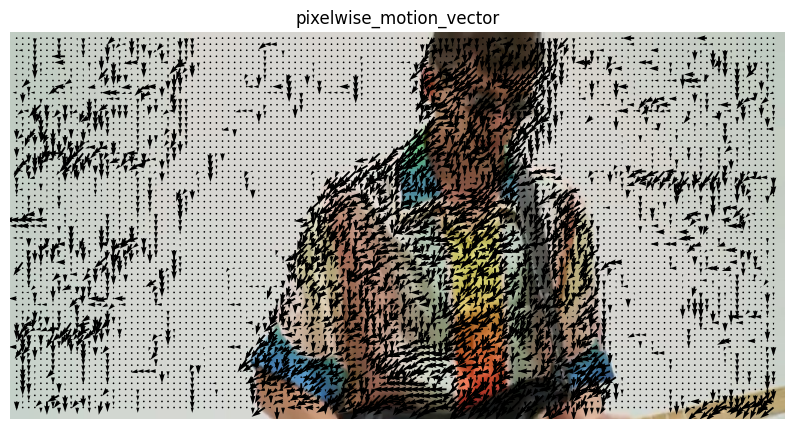

In [12]:
radius = 5
step = 5
width, height = F1.width, F1.height
V1, V2 = compute_motion_vectors(f1_grey, f2_grey, F1, width, height, radius, step, pixelwise_motion_vector, display=True, verbose=True)

Dans la première question, nous avons utilisé une méthode pixel par pixel pour calculer le vecteur de mouvement. Cette méthode prend en compte chaque pixel individuellement et cherche le meilleur pixel correspondant dans une fenêtre autour du pixel cible de la première image dans la deuxième image. 
Cela peut produire un champ de vecteurs bruité car chaque pixel est considéré indépendamment ce qui peut mener à des variations dans le mouvement.

# (B) Refaire cette même estimation par blocs (BMA) pour différentes tailles de blocs.

In [13]:
def blockwise_motion_vector(img1, img2, x, y, radius):
    """
    Compute the motion vector for a block centered at (x, y) by finding the block
    in img2 that minimizes the Displaced Frame Difference (DFD) with the block in img1.
    
    Parameters:
    img1 (numpy.ndarray): The first grayscale image.
    img2 (numpy.ndarray): The second grayscale image.
    x (int): The x-coordinate of the center of the block.
    y (int): The y-coordinate of the center of the block.
    radius (int): The radius of the block.
    
    Returns:
    tuple: The motion vector (a_x, a_y) minimizing the DFD for the current block.
    """
    # Initialize the minimum DFD to infinity and motion vector to (0, 0)
    min_dfd = np.inf
    motion_vector = (0, 0)
    
    # Generate the search range with a step size of radius/2
    search_range = np.arange(-2*radius, 2*radius+1, radius//2)
    
    # Iterate over the search range to find the block that minimizes the DFD
    for i in search_range:
        for j in search_range:
            # Compute the DFD for the current displacement
            dfd = 0
            for t1 in range(-radius, radius):
                for t2 in range(-radius, radius):
                    y1, x1 = y + t1, x + t2
                    y2, x2 = y + i + t1, x + j + t2
                    # Ensure indices are within the image boundaries
                    if (0 <= y2 < img1.shape[0] and 0 <= x2 < img1.shape[1]):
                        dfd += np.abs(img2[y2, x2] - img1[y1, x1])

            # Update the minimum DFD and corresponding motion vector if needed
            if dfd < min_dfd:
                min_dfd = dfd
                motion_vector = (j, i)
    
    return motion_vector

*** Start Compute Vector ***
==> Function: blockwise_motion_vector


100%|██████████| 31/31 [01:04<00:00,  2.09s/it]


==> End | Time: 64.69 seconds


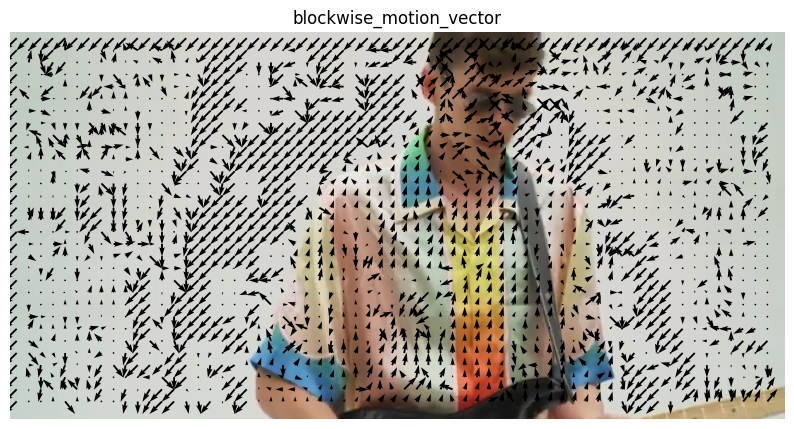

In [14]:
radius = 5
step = 10
width, height = F1.width, F1.height
V1, V2 = compute_motion_vectors(f1_grey, f2_grey, F1, width, height, radius, step, blockwise_motion_vector, display=True, verbose=True)

*** Start Compute Vector ***
==> Function: blockwise_motion_vector


100%|██████████| 15/15 [00:42<00:00,  2.84s/it]


==> End | Time: 42.55 seconds


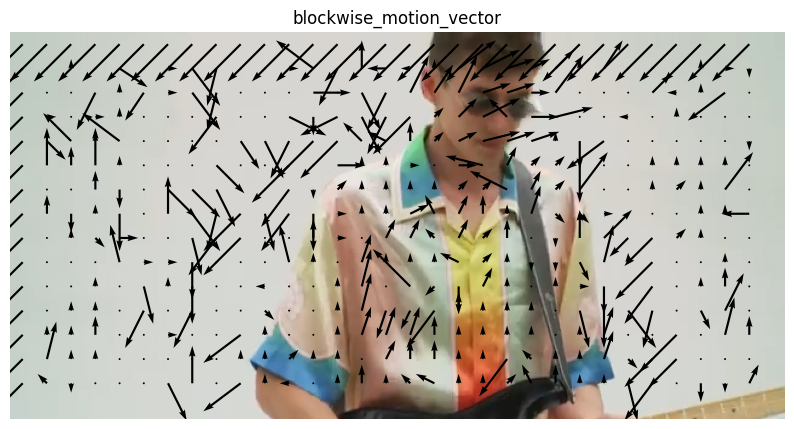

In [15]:
radius = 10
step = 20
width, height = F1.width, F1.height
V1, V2 = compute_motion_vectors(f1_grey, f2_grey, F1, width, height, radius, step, blockwise_motion_vector, display=True, verbose=True)

*** Start Compute Vector ***
==> Function: blockwise_motion_vector


100%|██████████| 7/7 [00:41<00:00,  5.89s/it]

==> End | Time: 41.23 seconds


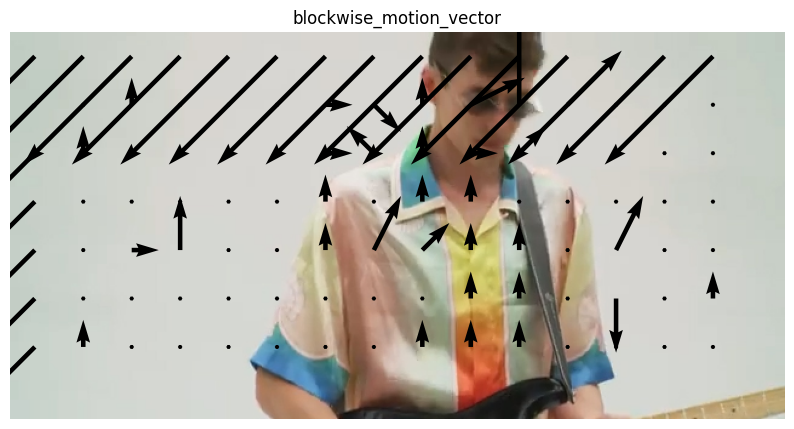

In [16]:
radius = 20
step = 40
width, height = F1.width, F1.height
V1, V2 = compute_motion_vectors(f1_grey, f2_grey, F1, width, height, radius, step, blockwise_motion_vector, display=True, verbose=True)

Pour la deuxième question, nous utilisons l'approche par bloc, où un bloc entier de pixels est comparé à un autre bloc dans la seconde image. Avec cette méthode, le vecteur de mouvement est calculé pour le bloc dans son ensemble, ce qui peut réduire le bruit, car l'information est moyennée sur plusieurs pixels. Mais cette méthode peut produire un champ de vecteurs moins précis.

# (C) Que déduisez-vous des deux premières questions ? (régularité du champs de vecteurs de mouvement vs. taille des blocs)

En comparant les résultats des deux méthodes, nous pouvons déduire que la taille des blocs a un impact significatif sur la régularité du champ des vecteurs de mouvement. Des blocs plus grands vont produire des champs de vecteurs plus réguliers mais moins détaillés, tandis que des blocs plus petits ou l'approche pixel par pixel peuvent capter plus de détails mais avec plus de sensibilité au bruit. Cela montre l'importance de choisir une taille de bloc appropriée, en équilibrant entre la précision des détails et la régularité du champ de vecteurs de mouvement.

# (D) Rajoutez une méthode de régularisation du champs de vecteurs de mou-vement de votre choix parmi les méthodes du cours et discutez pour quelles valeurs de coefficients le champs de vecteurs obtenu semble plus correspondre au flot optique.

Je n'ai pas réussi cette question mais je vais expliquer ce que j'ai compris sur la régularisation.

Je vais expliquer une méthode de régularisation est qui celle de Horn et Schunck.

Cette méthode repose sur 2 hypothèses:
- Luminance constante: L'intensité de la lumière de chaque pixel reste constant entre les images
- Régularité du mouvement: Les vecteurs de mouvement doivent varier de manière lisse à travers l'image, sauf dans les bords des objets en mouvement.

Cette méthode exprime les hypothèses sous la forme d'une fonction d'erreur que l'on cherche à minimiser.

Voici l'algorithme que j'ai essayé d'implémenter:

- **Calcule des dérivées**
- **Initialisation des champs de vecteurs V1 et V2 à 0**
- **Minimiser la fonction d'erreur**: utilisation de la descente de gradient (vu en OCVX)
- **Régularisation**: J'applique le terme de régularisation en utilisant une moyenne locale des vecteurs de mouvement voisins. Cela va lisser le champ de vecteurs. 